## [Computational Social Science] Project 5: Natural Language Processing

#### Hyemin Park

## PART 0: Base

In [1]:
###' ################################################################################
###'
###' IMPORT LIBRARIES
###'
###'

### pandas and numpy
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt

### punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
from spellchecker import SpellChecker
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import en_core_web_sm
nlp = en_core_web_sm.load()
import scattertext as st

### textblob
from textblob import TextBlob

### countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### gensim
import gensim
from gensim import models

### plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### kMeans and silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### ignore warnings
import warnings
warnings.filterwarnings('ignore')

###time
from datetime import datetime

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
###' ################################################################################
###'
###' Data Load 
###'
###'

### data load
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")


### confirm generated data
congress_tweets.head(n=5)

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


## PART 1: Data Processing

In [3]:
###' ################################################################################
###'
###' Data Generation
###'
###'

### create age column
congress_tweets['date'] = congress_tweets['datetime'].str[:10]
congress_tweets['birthday'] = pd.to_datetime(congress_tweets['birthday'])
congress_tweets['age'] = pd.to_numeric(congress_tweets['date'].str[:4]) - congress_tweets['birthday'].dt.year


### confirm generated data
congress_tweets.head(n=5)

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,date,age
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,1955-02-16,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",2019-01-03,64
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,1955-02-16,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",2019-01-03,64
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,1955-02-16,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",2019-01-03,64
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,1955-02-16,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",2019-01-03,64
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,1955-02-16,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925",2019-01-03,64


In [4]:
###' ################################################################################
###'
###' Sellect Data
###'
###'

### select columns
congress_tweets_sel = congress_tweets[['tweet_id','party','position','gender','age','text']]
tweets = congress_tweets_sel.dropna(subset = ['text'])


### sample
tweets_party = pd.concat([tweets[tweets['party'] == 'Republican'].sample(3000, random_state = 224),
                          tweets[tweets['party'] == 'Democrat'].sample(3000, random_state = 224),
                          tweets[tweets['party'] == 'Independent'].sample(3000, random_state = 224)]).reset_index(drop = True)

In [30]:
###' ################################################################################
###'
###' Spell check for Random Sampled Text
###'
###'

### load spell checker
spell = SpellChecker()

### text spell check
tweets_party['text_spell'] = tweets_party['text'].map(lambda x: spell.correction(x))

### confirm generated data
tweets_party.head(n=10)

,tweet_id,party,position,gender,age,text,text_spell,tokens,text_len,word_count,tokens_join,polarity,subjectivity
0,1.227000e+18,Republican,Rep,M,60,Ever had this happen? You make a reservation a...,Ever had this happen? You make a reservation a...,"[happen, reservation, hotel, charge, resort, f...",299.0,47.0,happen reservation hotel charge resort fee ’ r...,0.285714,0.535714
1,1.274420e+18,Republican,Sen,M,63,ICYMI: Seniors are willing and able to give ba...,ICYMI: Seniors are willing and able to give ba...,"[ICYMI, senior, willing, able, community, Covi...",390.0,40.0,ICYMI senior willing able community Covid19 pr...,0.375000,0.687500
2,1.274060e+18,Republican,Sen,M,46,At Minton Park and Ballfield @SecretarySonny a...,At Minton Park and Ballfield @SecretarySonny a...,"[Minton, Park, Ballfield, SecretarySonny, I, s...",342.0,35.0,Minton Park Ballfield SecretarySonny I speak l...,0.266667,0.333333
3,1.093520e+18,Republican,Rep,M,48,I was thrilled to join @Pinecrest_MCS to recog...,I was thrilled to join @Pinecrest_MCS to recog...,"[I, thrilled, join, pinecrestmcs, recognize, C...",261.0,21.0,I thrilled join pinecrestmcs recognize Chris M...,0.550000,0.600000
4,1.243150e+18,Republican,Rep,M,63,The Senate “emergency” bill allows sanctuary c...,The Senate “emergency” bill allows sanctuary c...,"[Senate, "", emergency, "", bill, allow, sanctua...",374.0,39.0,"Senate "" emergency "" bill allow sanctuary city...",0.200000,0.200000
5,1.174680e+18,Republican,Rep,M,64,RT @HouseCommerce All 2️⃣4️⃣ E&amp;C Republica...,RT @HouseCommerce All 2️⃣4️⃣ E&amp;C Republica...,"[HouseCommerce, 2️⃣4️⃣, EampC, Republicans, cr...",375.0,30.0,HouseCommerce 2️⃣4️⃣ EampC Republicans critici...,0.000000,0.000000
6,1.225900e+18,Republican,Rep,M,62,Good riddance. https://twitter.com/jenniferjja...,Good riddance. https://twitter.com/jenniferjja...,"[good, riddance, JenniferJJacobs, BREAKING, Al...",204.0,22.0,good riddance JenniferJJacobs BREAKING Alex Vi...,0.350000,0.300000
7,1.242310e+18,Republican,Rep,M,48,RT @DanScavino #WashYourHands #SlowTheSpread\n...,RT @DanScavino #WashYourHands #SlowTheSpread\n...,"[DanScavino, washyourhands, SlowTheSpread, cov...",124.0,6.0,DanScavino washyourhands SlowTheSpread covidー19 🌐,0.000000,0.000000
8,1.257800e+18,Republican,Rep,M,49,@tbcw13 @usaf__vet This sentence could really ...,@tbcw13 @usaf__vet This sentence could really ...,"[tbcw13, usafvet, sentence, use, comma, imma, ...",102.0,15.0,tbcw13 usafvet sentence use comma imma like sa...,0.000000,0.000000
9,1.141340e+18,Republican,Rep,M,47,"RT @thehill .@RepChipRoy: ""[Rep. @AOC suggeste...","RT @thehill .@RepChipRoy: ""[Rep. @AOC suggeste...","[thehill, repchiproy, Rep, AOC, suggest, presi...",457.0,45.0,thehill repchiproy Rep AOC suggest president r...,0.000000,0.100000


In [31]:
###' ################################################################################
###'
###' Function for Deleteing Punctuations and StopWords
###'
###'

### define fuction
def rem_punc_stop(text):
    
    # when text is None
    if text is None:  
        return None
    
    # add more stop words
    stop_words = STOP_WORDS 
    nlp.Defaults.stop_words |= {"monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday",
                    "january", "february", "march", "april", "may", "june", "july", "august", "september", 
                    "october", "november", "december", "time", "today", "yesterday", "tomorrow", 
                    "day", "week", "month", "year","amp","RT","QT"}
    
    punc = set(punctuation)
    
    
    # remove the punctuation
    punc_free = "".join([ch for ch in text if ch not in punc])                                                               

    # apply nlp to punctuation-free object
    doc = nlp(punc_free)
    
    # lemmatize
    text_lemma = " ".join([word.lemma_ for word in doc])
    
    # extract words from processed text 
    spacy_words = text_lemma.split()
    spacy_words_1 = [word for word in spacy_words if not word.startswith("@")]
    spacy_words_2 = [word for word in spacy_words_1 if not word.startswith("http")]
    
    
    # filter out words 
    no_stop = [word for word in spacy_words_2 if word not in stop_words]
    
    # return
    return no_stop

In [32]:
###' ################################################################################
###'
###' Apply the Function and Tokenize Text Column
###'
###'

### sample from the whole dataset
tweets_party['tokens'] = tweets_party['text_spell'].map(lambda x: rem_punc_stop(x))


### confirm generated data
tweets_party['tokens']

0       [happen, reservation, hotel, charge, resort, f...
1       [ICYMI, senior, willing, able, community, Covi...
2       [Minton, Park, Ballfield, SecretarySonny, I, s...
3       [I, thrilled, join, pinecrestmcs, recognize, C...
4       [Senate, ", emergency, ", bill, allow, sanctua...
                              ...                        
8995    [happy, help, ARCMaine, important, ", sound, A...
8996    [PplsAction, need, defeat, dangerous, presiden...
8997    [I, lot, thing, I, inconsistent, country, join...
8998    [farmworker, unrecognized, vital, contribution...
8999    [Supreme, Court, allow, Michigan, continue, ge...
Name: tokens, Length: 9000, dtype: object

## PART 2: Text Explore

### 1. Word Cloud

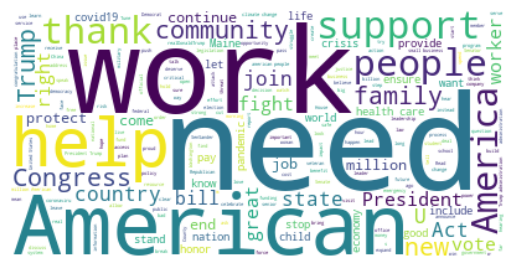

In [33]:
###' ################################################################################
###'
###' VISUALIZATION : Word Cloud
###' by. party
###'
###'

### 0. Sample from Whole data

# apply function to text object
TO_text = ' '.join(tweets_party['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
TO_wordcloud = WordCloud(background_color = "white",
                      random_state=41).generate(TO_text)          

# plot 
plt.imshow(TO_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')                       
plt.show()                            

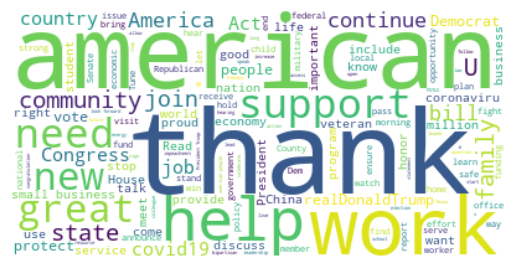

In [34]:
### 1. REPUBLIC

# apply function to text object
RE_text = ' '.join(tweets_party[tweets_party['party'] == 'Republican']['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
RE_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(RE_text)          

# plot 
plt.imshow(RE_wordcloud,
           interpolation = 'bilinear')
plt.axis('off')                       
plt.show()   

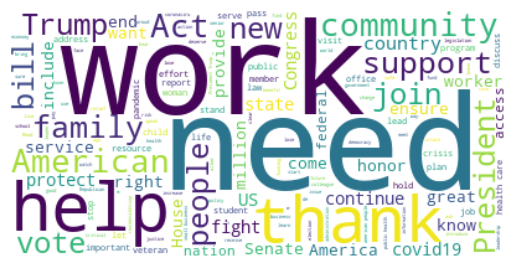

In [35]:
### 2. DEMOCRAT

# apply function to text object
DE_text = ' '.join(tweets_party[tweets_party['party'] == 'Democrat']['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
DE_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(DE_text)         

# plot 
plt.imshow(DE_wordcloud,                
           interpolation = 'bilinear') 
plt.axis('off')                        
plt.show()                             

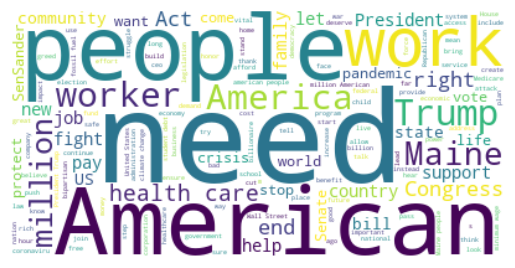

In [36]:
### 3. INDEPENDENT

# apply function to text object
IN_text = ' '.join(tweets_party[tweets_party['party'] == 'Independent']['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
IN_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(IN_text)          

# plot 
plt.imshow(IN_wordcloud,               
           interpolation = 'bilinear') 
plt.axis('off')                        
plt.show()                             

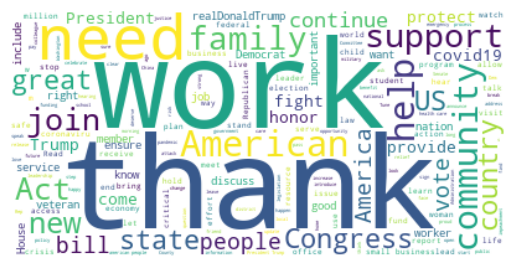

In [37]:
###' ################################################################################
###'
###' VISUALIZATION : Word Cloud
###' by. position
###'
###'

### 1. REPRESENTITIVE

# apply function to text object
REP_text = ' '.join(tweets_party[tweets_party['position'] == 'Rep']['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
REP_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(REP_text)         

# plot 
plt.imshow(REP_wordcloud,             
           interpolation = 'bilinear')
plt.axis('off')                       
plt.show()                            

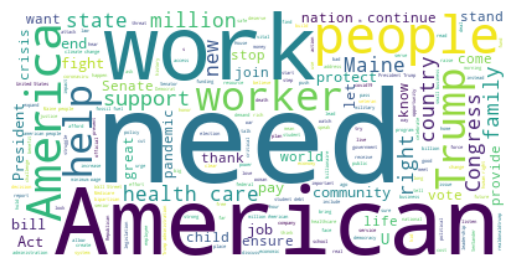

In [38]:
### 2. SENATOR

# apply function to text object
SEN_text = ' '.join(tweets_party[tweets_party['position'] == 'Sen']['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else ""))

# create WordCloud visualization using the "text" object 
SEN_wordcloud = WordCloud(background_color = "white",
                      random_state=41              
                      ).generate(SEN_text)         

# plot 
plt.imshow(SEN_wordcloud,              
           interpolation = 'bilinear') 
plt.axis('off')                        
plt.show()                             

### 2. Word Features

In [39]:
###' ################################################################################
###'
###' GENERATE TEXT FEATURES
###' e.g. text_len, word count, polarity, subjectivity
###'
###'


# text_len & count
tweets_party['text_len'] = tweets_party['text_spell'].dropna().apply(len)
tweets_party['word_count'] = tweets_party['text_spell'].dropna().apply(lambda x: len(str(x).split()))


# join token
tweets_party['tokens_join'] = tweets_party['tokens'].map(lambda text: ' '.join(text) if isinstance(text, list) else "")


# polarity & subjectivity
tweets_party['polarity'] = tweets_party['tokens_join'].map(lambda text: TextBlob(text).sentiment.polarity)
tweets_party['subjectivity'] = tweets_party['tokens_join'].map(lambda text: TextBlob(text).sentiment.subjectivity)


### confirm generated data
tweets_party.head(n=5)

,tweet_id,party,position,gender,age,text,text_spell,tokens,text_len,word_count,tokens_join,polarity,subjectivity
0,1.227000e+18,Republican,Rep,M,60,Ever had this happen? You make a reservation a...,Ever had this happen? You make a reservation a...,"[happen, reservation, hotel, charge, resort, f...",299.0,47.0,happen reservation hotel charge resort fee ’ r...,0.285714,0.535714
1,1.274420e+18,Republican,Sen,M,63,ICYMI: Seniors are willing and able to give ba...,ICYMI: Seniors are willing and able to give ba...,"[ICYMI, senior, willing, able, community, Covi...",390.0,40.0,ICYMI senior willing able community Covid19 pr...,0.375000,0.687500
2,1.274060e+18,Republican,Sen,M,46,At Minton Park and Ballfield @SecretarySonny a...,At Minton Park and Ballfield @SecretarySonny a...,"[Minton, Park, Ballfield, SecretarySonny, I, s...",342.0,35.0,Minton Park Ballfield SecretarySonny I speak l...,0.266667,0.333333
3,1.093520e+18,Republican,Rep,M,48,I was thrilled to join @Pinecrest_MCS to recog...,I was thrilled to join @Pinecrest_MCS to recog...,"[I, thrilled, join, pinecrestmcs, recognize, C...",261.0,21.0,I thrilled join pinecrestmcs recognize Chris M...,0.550000,0.600000
4,1.243150e+18,Republican,Rep,M,63,The Senate “emergency” bill allows sanctuary c...,The Senate “emergency” bill allows sanctuary c...,"[Senate, "", emergency, "", bill, allow, sanctua...",374.0,39.0,"Senate "" emergency "" bill allow sanctuary city...",0.200000,0.200000


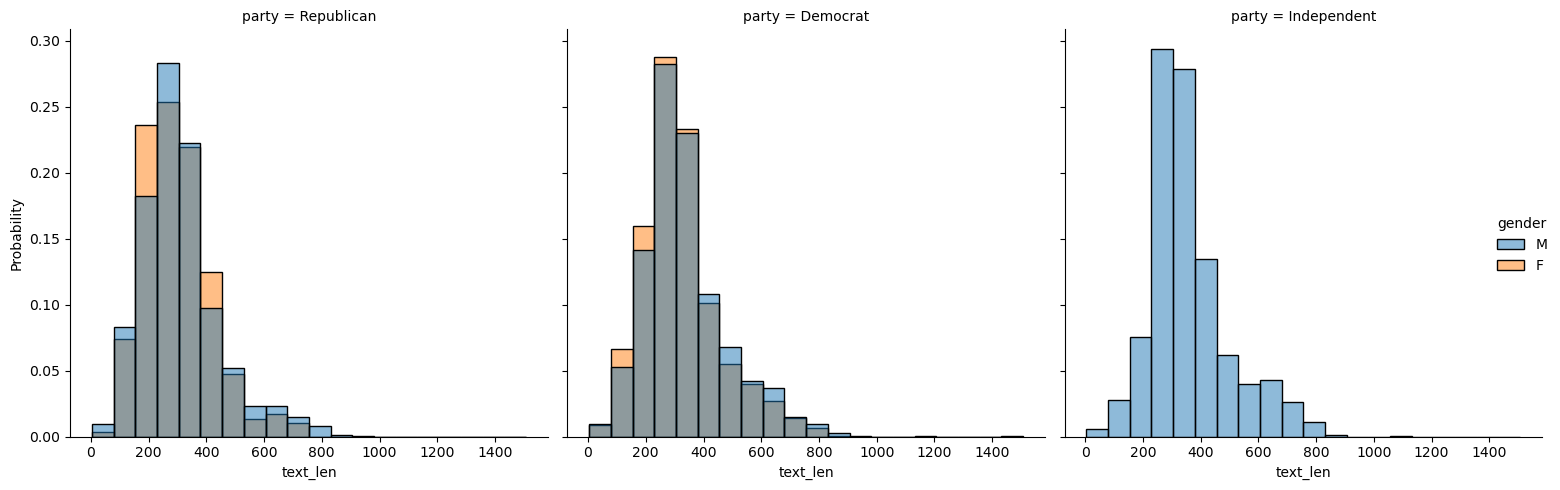

In [40]:
###' ################################################################################
###'
###' VISUALIZATION TEXT FEATURES
###' by. party
###'
###'

### 1. compare text len
sns.displot(tweets_party,    
            x="text_len",  
            hue = "gender",
            stat = "probability",
            common_norm = False, 
            col = "party",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

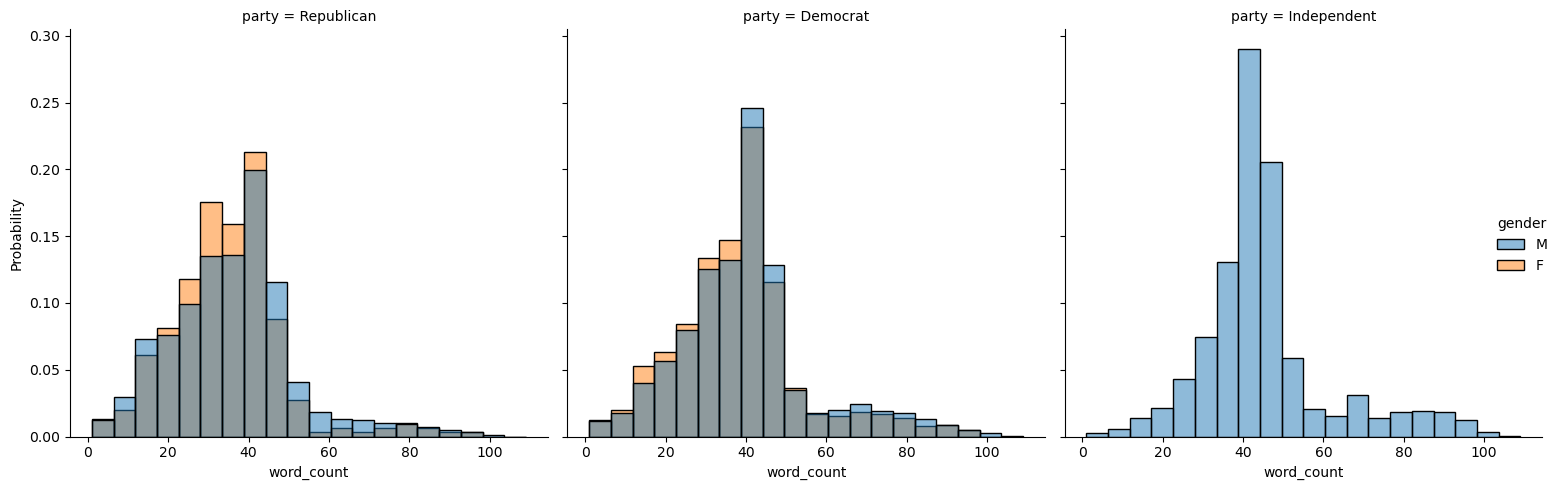

In [41]:
### 2. compare word count
sns.displot(tweets_party,    
            x="word_count",  
            hue = "gender", 
            stat = "probability",
            common_norm = False, 
            col = "party",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

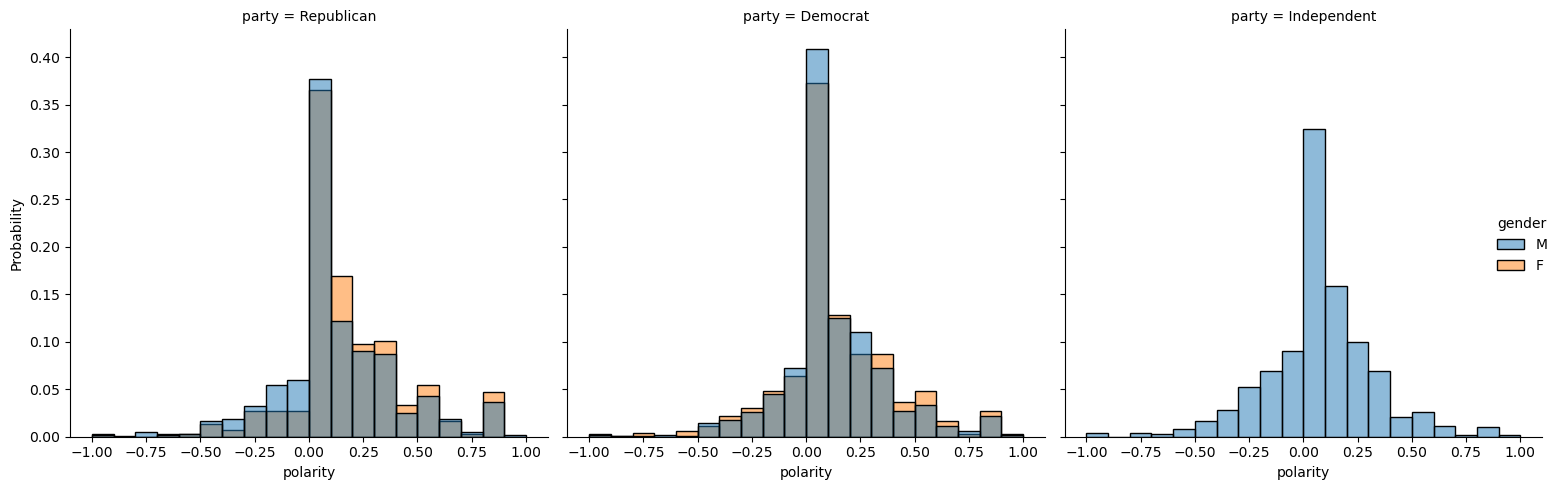

In [42]:
### 3. compare polarity
sns.displot(tweets_party,    
            x="polarity",  
            hue = "gender", 
            stat = "probability",
            common_norm = False, 
            col = "party",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

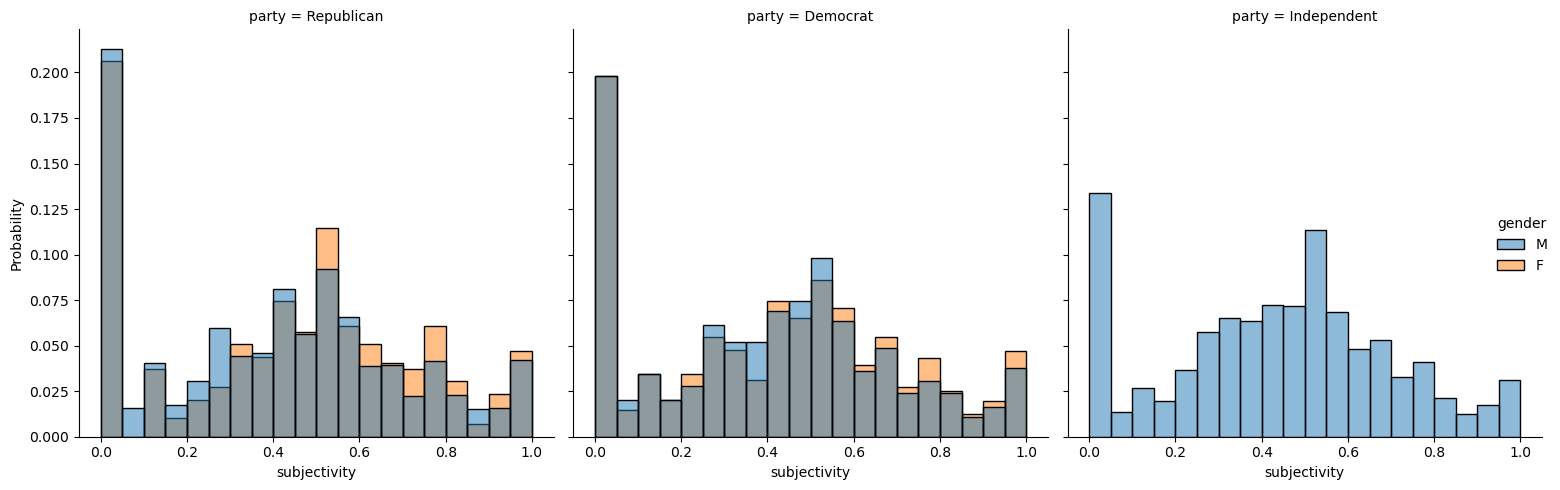

In [43]:
### 4. compare subjectivity
sns.displot(tweets_party,    
            x="subjectivity",  
            hue = "gender", 
            stat = "probability",
            common_norm = False,
            col = "party",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

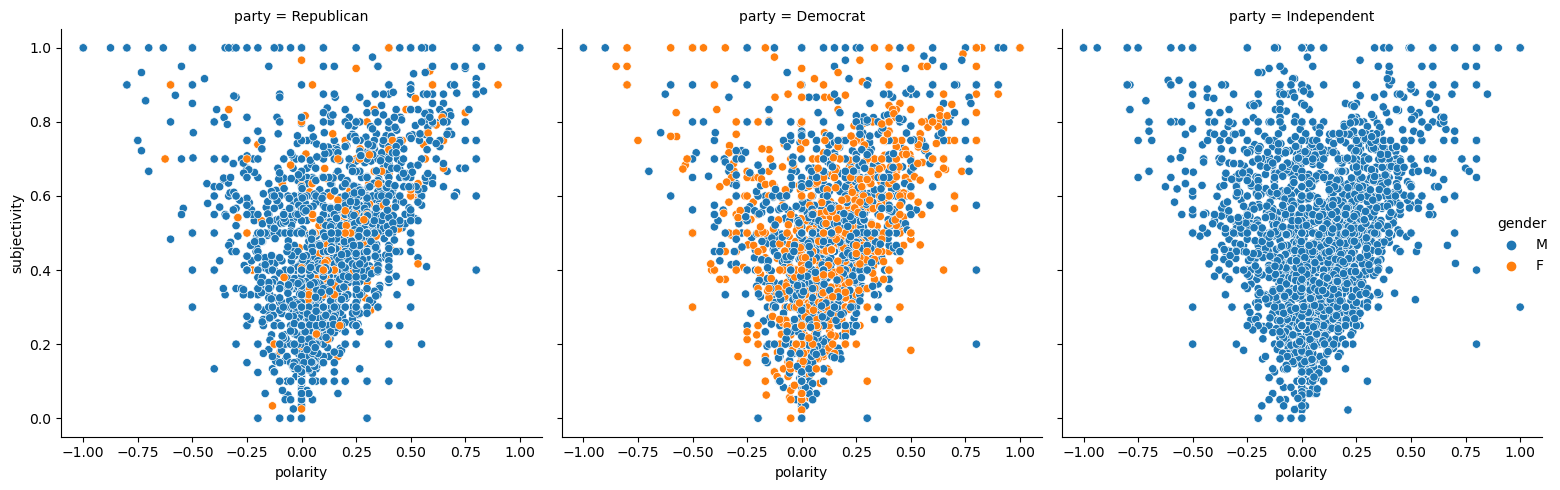

In [44]:
### 5. compare scatter plot of polarity and subjectivity

sns.relplot(data = tweets_party,
            x="polarity",
            y="subjectivity",
            hue = "gender",
            col='party',
            kind = "scatter")

# show graph
plt.tight_layout()
plt.show()

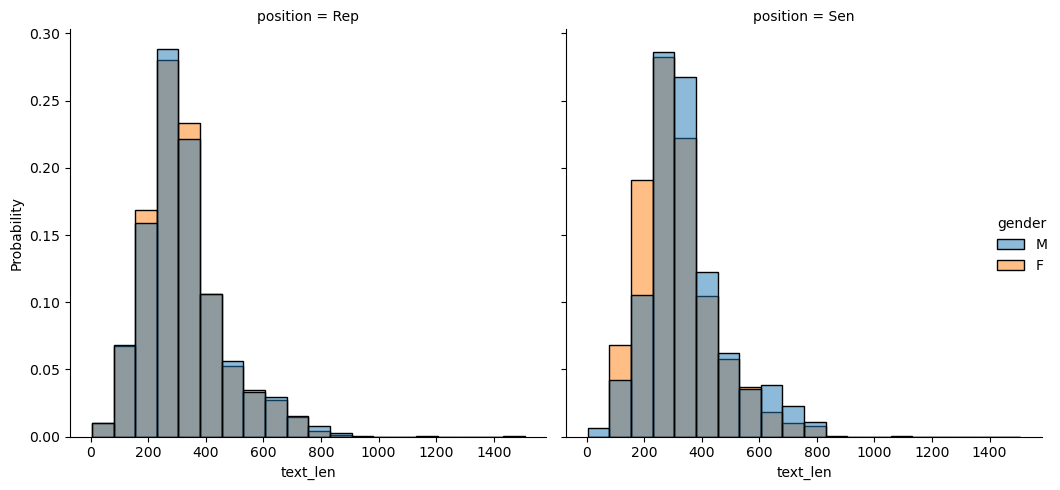

In [45]:
###' ################################################################################
###'
###' VISUALIZATION TEXT FEATURES
###' by. position
###'
###'

### 1. compare text len
sns.displot(tweets_party,    
            x="text_len",  
            hue = "gender",
            stat = "probability",
            common_norm = False, 
            col = "position",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

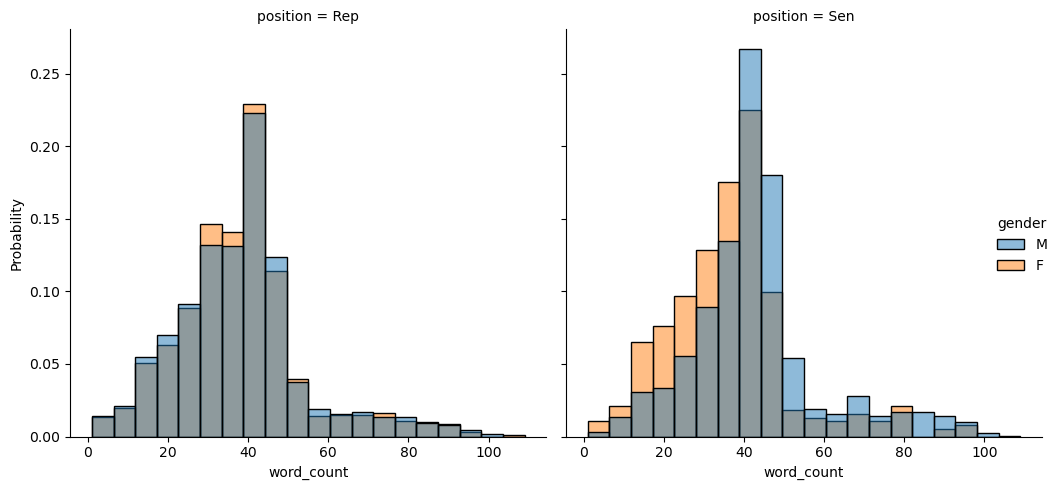

In [46]:
### 2. compare word count
sns.displot(tweets_party,    
            x="word_count",  
            hue = "gender",
            stat = "probability",
            common_norm = False, 
            col = "position",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

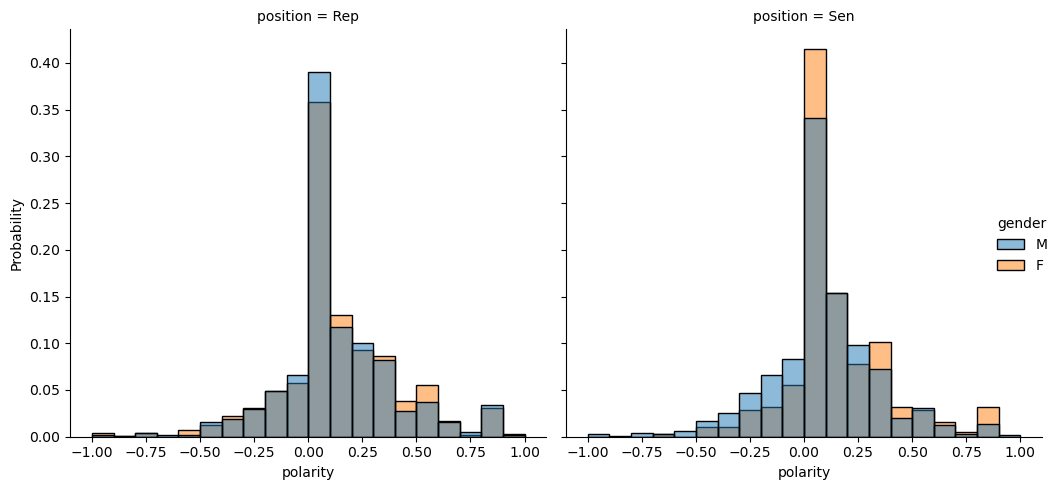

In [47]:
### 3. compare polarity
sns.displot(tweets_party,    
            x="polarity",  
            hue = "gender",
            stat = "probability",
            common_norm = False, 
            col = "position",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

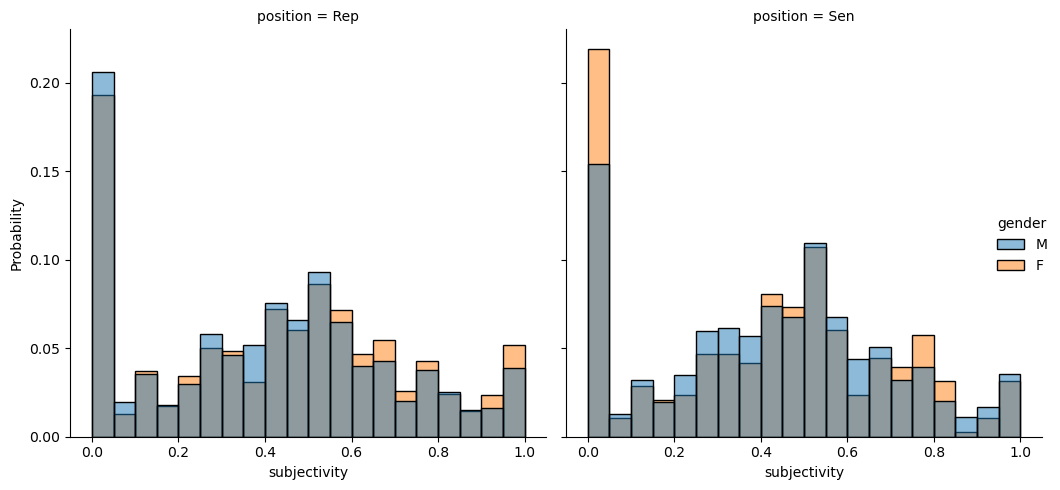

In [48]:
### 4. compare subjectivity
sns.displot(tweets_party,    
            x="subjectivity",  
            hue = "gender",
            stat = "probability",
            common_norm = False, 
            col = "position",
            bins = 20)

# show graph
plt.tight_layout()
plt.show()

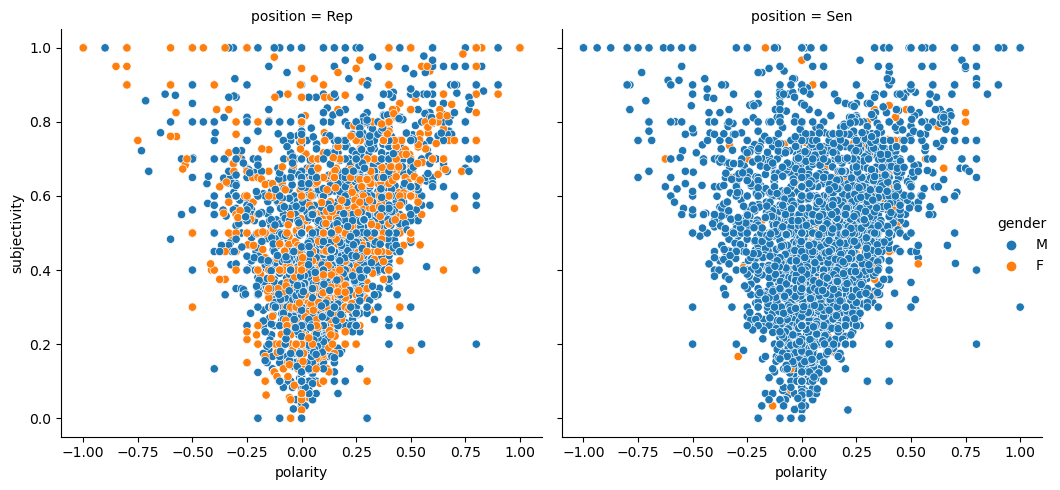

In [49]:
### 5. compare scatter plot of polarity and subjectivity
sns.relplot(data = tweets_party,
            x="polarity",
            y="subjectivity",
            hue = "gender",
            col='position',
            kind = "scatter")

# show graph
plt.tight_layout()
plt.show()

### 3. Scatter Text

In [50]:
###' ################################################################################
###'
###' VISUALIZATION : SCATTER TEXT
###' by. party
###'
###'

tweets_party_part = tweets_party[tweets_party['party'] != 'Independent']
#tweets_party_part_S = tweets_party_part[:300].dropna()

### create measure of subjectivity
corpus = st.CorpusFromPandas(tweets_party_part,
                             category_col='party',
                             text_col='tokens_join',
                             nlp=nlp).build()
### create html document
html = st.produce_scattertext_explorer(corpus,
                                       category='Republican',
                                       category_name='Republican',
                                       not_category_name='Democrat',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5
                                       #metadata=congress_tweets_part
                                      )


### save as html
open("Project5_ScatterText_party.html", 'wb').write(html.encode('utf-8'))

2451928

In [51]:
import webbrowser
import os

# HTML
html_file_path = "C:/Users/OWNER/SOCIOL_273M/Project5_ScatterText_party.html"
html_file_url = "file://" + os.path.realpath(html_file_path)
webbrowser.open_new_tab(html_file_url)

True

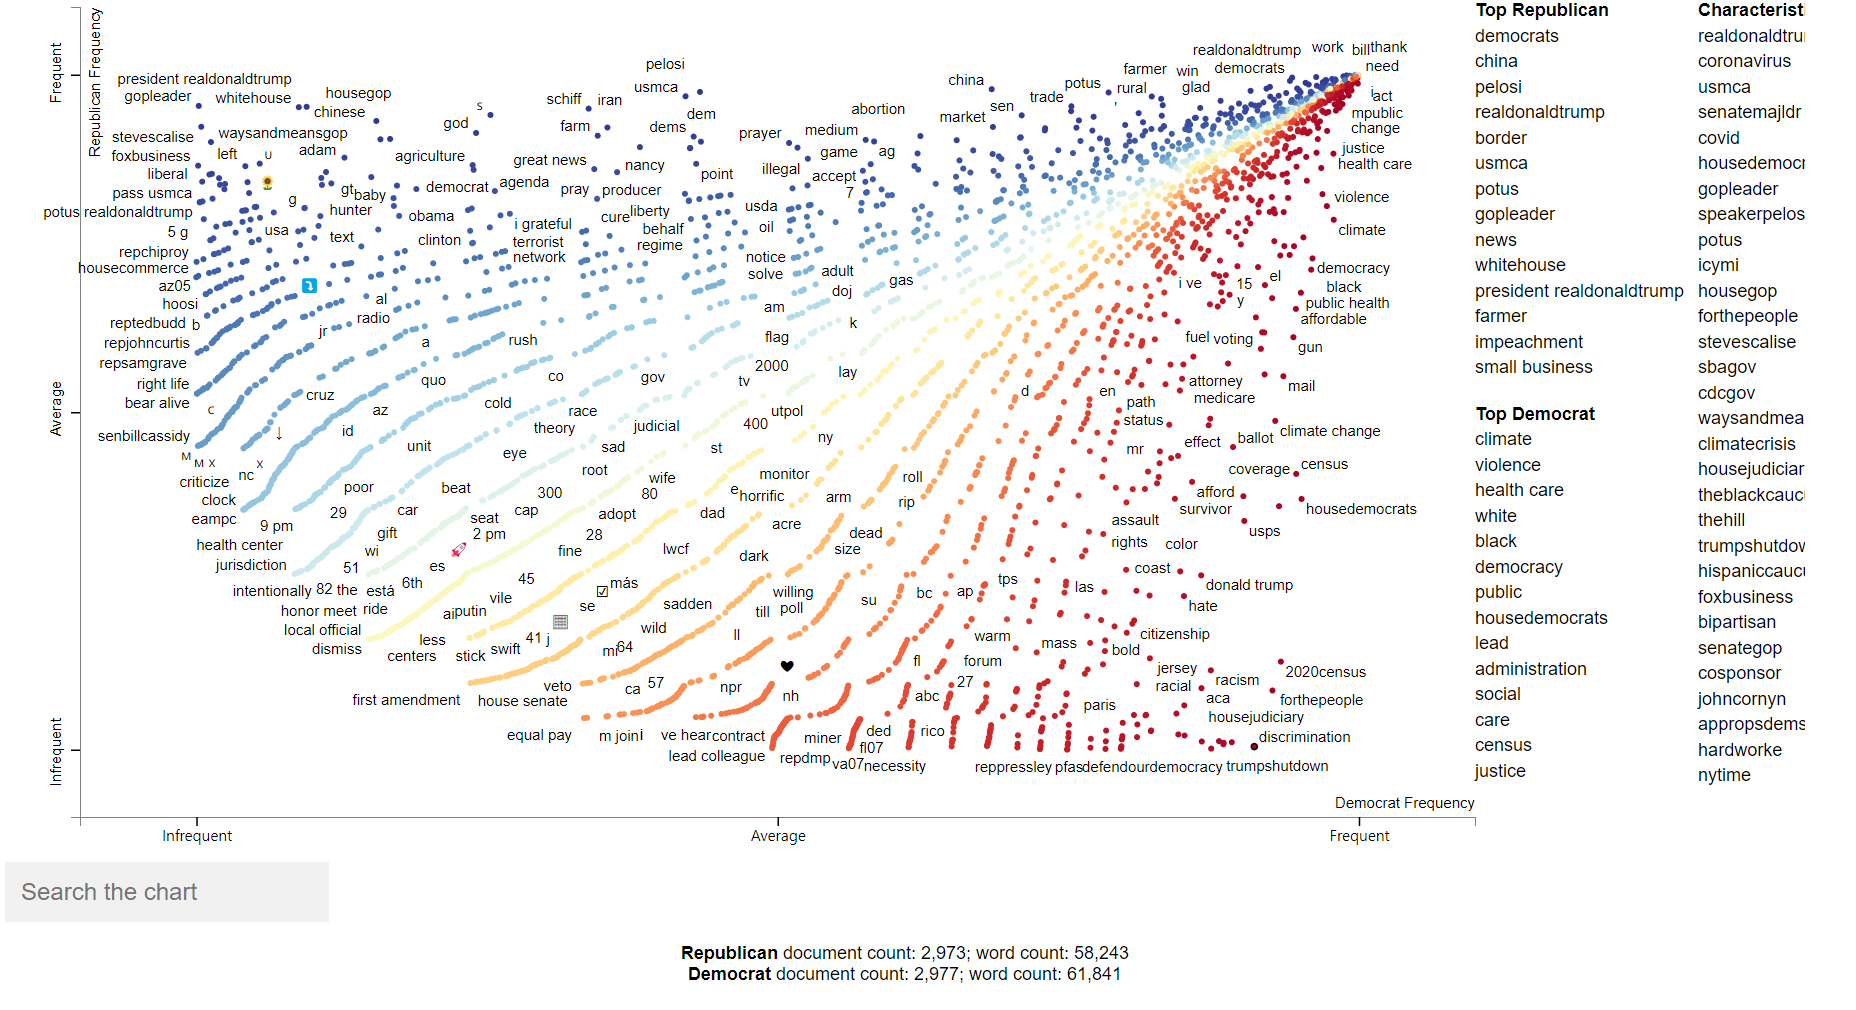

In [52]:
###' ################################################################################
###'
###' VISUALIZATION : SCATTER TEXT
###' by. position
###'
###'


### create measure of subjectivity
corpus = st.CorpusFromPandas(tweets_party,
                             category_col='position',
                             text_col='tokens_join',
                             nlp=nlp).build()
### create html document
html = st.produce_scattertext_explorer(corpus,
                                       category='Rep',
                                       category_name='Rep',
                                       not_category_name='Rep',
                                       width_in_pixels=1000,
                                       minimum_term_frequency=5
                                       #metadata=congress_tweets_part
                                      )


### save as html
open("Project5_ScatterText_position.html", 'wb').write(html.encode('utf-8'))

3499209

### PART 3. Frequent Words

In [54]:
# test a count vectorizer
# ----
count = CountVectorizer()
count_mx = count.fit_transform(tweets_party['tokens_join'][0:2])

# convert matrix to dataframe
count_df = pd.DataFrame(
    data = count_mx.toarray(), 
    columns = count.get_feature_names_out()) 

count_df.iloc[1]

able             1
baitandswitch    0
bill             1
charge           0
community        1
concern          1
corps            1
covid19          1
deceptive        0
discuss          0
end              0
fee              0
happen           0
health           2
hotel            0
icymi            1
invite           0
involve          1
member           1
mission          1
nbc              0
news             0
nightly          0
practice         0
prevent          1
protect          1
reservation      0
resort           0
right            0
senior           2
story            0
support          1
watch            0
willing          1
Name: 1, dtype: int64

## PART 4. Featurization